In [1]:
import numpy as np
from numpy import linalg as la
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp

In [2]:
def updateParams(c,ul,vl,vs,w1l,w2l,r=10.,
                       l=1e-2,alg = "GN"):
    
    grad = np.array([np.dot(vl-ul,w1l),np.dot(vl-ul,w2l)])
    wmat = np.array([[np.dot(w1l,w1l),np.dot(w1l,w2l)]
                     ,[np.dot(w1l,w2l),np.dot(w2l,w2l)]])
    err = np.dot(vl-ul,vl-ul)
    I = np.identity(2)
    
    dc = np.zeros(2)
    
    w1l_A = 1/mu*np.sum(vs,axis=1)*vl
    w2l_A = -1/mu*vl
    
    grad_A = np.array([np.dot(vl-ul,w1l_A),np.dot(vl-ul,w2l_A)])
    wmat_A = np.array([[np.dot(w1l_A,w1l_A),np.dot(w1l_A,w2l_A)]
                     ,[np.dot(w1l_A,w2l_A),np.dot(w2l_A,w2l_A)]])
    
    if alg == "grad":
        dc = - r*grad
    if alg == "newton":
        dc = - err/(np.dot(grad,grad)+1e-35)*grad
    if alg == "GN":
        dc =- np.linalg.solve(wmat, grad)
    if alg == "LM":
        dc =- np.linalg.solve(wmat+l*I, grad)
    if alg == "grad_A":
        dc = - r*grad_A
    if alg == "newton_A":
        dc = - err/(np.dot(grad_A,grad_A)+1e-35)*grad_A
    if alg == "GN_A":
        dc = - np.linalg.solve(wmat_A, grad_A)
    if alg == "LM_A":
        dc =- np.linalg.solve(wmat_A + l*I, grad_A)
    ctest = c + dc
    if ctest[0] > 0:
        return ctest
    else:
        return c +dc

In [3]:
def system(t,state,I,J,g,c,F,d,mu):
    #reshaping the input dependent variables
    u = state[0:I*(J+1)]
    v = state[I*(J+1):2*I*(J+1)]
    w1 = state[2*I*(J+1):3*I*(J+1)]
    w2 = state[3*I*(J+1):]
    
    # Define u and v 
    ul = u[0:I]
    us = np.reshape(u[I:],(I,J))
    # Create index offsets
    ul_1 = np.concatenate(([ul[-1]],ul[0:-1]))# u_{i+1}
    ul__1 = np.concatenate((ul[1:],[ul[0]]))#u_{i-1}
    ul_2 = np.concatenate((ul[-2:],ul[0:-2]))#u_{i+2}
    # Actual differential Equation
    dul = (ul_1*(ul__1-ul_2) 
          + np.sum(us,axis=1)*g[0]*ul 
          - g[1]*ul +F) 
    dus = (-np.tile(d,(I,1))*us 
          - np.transpose(np.tile(g[0]*ul**2,(J,1))))
    
    # Define nudged variables
    vl = v[0:I]
    vs = np.reshape(v[I:],(I,J))
    # Index offsets for nudged variables
    vl_1 = np.concatenate(([vl[-1]],vl[0:-1]))
    vl__1 = np.concatenate((vl[1:],[vl[0]]))
    vl_2 = np.concatenate((vl[-2:],vl[0:-2]))    
    # Nudged system 
    dvl = (vl_1*(vl__1-vl_2) 
           + np.sum(vs,axis=1)*c[0]*vl 
           - c[1]*vl + F - mu*(vl-ul))
    dvs = (-np.tile(d,(I,1))*vs 
           - np.transpose(np.tile(c[0]*vl**2,(J,1))))
    
    # First Sensitivity Equation
    w1l = w1[0:I]
    w1s = np.reshape(w1[I:],(I,J))
    # Index offsets 
    w1l_1 = np.concatenate(([w1l[-1]],w1l[0:-1]))
    w1l__1 = np.concatenate((w1l[1:],[w1l[0]]))
    w1l_2 = np.concatenate((w1l[-2:],w1l[0:-2]))    
    #Sensitivity Equation 1
    dw1l = (w1l_1*(vl__1 - vl_2)
           + vl_1*(w1l__1 - w1l_2)
           + np.sum(vs,axis=1)*vl 
           + np.sum(w1s, axis=1)*c[0]*vl
           + np.sum(vs, axis=1)*c[0]*w1l
           - c[1]*w1l - mu*w1l)
    dw1s = (-np.tile(d,(I,1))*w1s
           - np.transpose(np.tile(vl**2,(J,1)))
           - np.transpose(np.tile(2*c[0]*vl*w1l,(J,1))))
    
    # Second Sensitivity Equation
    w2l = w2[0:I]
    w2s = np.reshape(w2[I:],(I,J))
    # Index offset
    w2l_1 = np.concatenate(([w1l[-1]],w1l[0:-1]))
    w2l__1 = np.concatenate((w1l[1:],[w1l[0]]))
    w2l_2 = np.concatenate((w1l[-2:],w1l[0:-2]))    
    #Sensitivity Equation 2
    dw2l = (w2l_1*(vl__1 - vl_2)
           + vl_1*(w2l__1 - w2l_2)
           + np.sum(w2s, axis=1)*c[0]*vl
           + np.sum(vs, axis=1)*c[0]*w2l
           - vl
           - c[1]*w2l - mu*w2l)
    dw2s = (-np.tile(d,(I,1))*w2s 
           - np.transpose(np.tile(2*c[0]*vl*w2l,(J,1))))
    
    return np.concatenate((dul,np.reshape(dus,(I*J)),
                           dvl,np.reshape(dvs,(I*J)),
                           dw1l, np.reshape(dw1s,(I*J)),
                           dw2l, np.reshape(dw2s,(I*J))
                          ))

In [4]:
#set the dimensions of the system,
# I is the number of large scale systems 
# and J the number of small scale terms per each large scale
I=100
J=5
size=I*(J+1)


# Running Parameters
N = 100 # Number of parameter updates
t,dt = 0, 5.0
n=400 # Number of steps per run


# Initial Conditions
u0 = np.zeros(size)
u0[:I] = np.sin(2*np.pi*np.arange(I)/I)
v0 = np.zeros(size)
w10 = np.zeros(size)
w20 = np.zeros(size)
# Initial State
state0 = np.concatenate([u0,v0,w10,w20])


# Learning Parameters
g = np.array([1e-2,0.5]) # True
paramErr = np.abs(np.random.randn(2)*1e-1)
c_init = 2*g  # Approximate
# Fixed Parameters
d = np.array([0.2,0.5,1,2,5]) #dissipation coefficients for the v_{k,j}
F=8. #forcing constant
mu=50.


# Initialize variables
state = np.array((size,n))
u = np.array((size,n))
v = np.array((size,n))
w1 = np.array((size,n))
w2 = np.array((size,n))
c = c_init

# Lists
# variables
ts = []
us = []
vs = []
w1s = []
w2s = []
# parameters
cs = [c_init]


for i in range(N):
    print(i)
    # Integrate the system
    soln = solve_ivp(system, (t,t+dt), 
                     state0,
                     args = (I,J,g,c,F,d,mu), dense_output=True)
    
    # Interpolate in time
    trange = np.linspace(t,t+dt,n)
    #print(i)
    state = soln.sol(trange)
    #print(state.shape)
    u = state[0:size,:]
    v = state[size:2*size,:]
    w1 = state[2*size:3*size,:]
    w2 = state[3*size:,:]
    
    # Update time and initial conditions
    state0 = state[:,-1]
    t += dt
    
    ulmean = np.mean(u[:I,-100:],axis=1)
    vmean = np.mean(v[:,-100:],axis=1)
    w1lmean = np.mean(w1[:I,-100:], axis = 1)
    w2lmean = np.mean(w2[:I,-100:], axis = 1)
    
    c = updateParams(c,ulmean,vmean[:I],np.reshape(vmean[I:],(I,J)),
                       w1lmean,w2lmean,alg="LM_A",r=5e-2,l=1e-9)
    
    #c = updateParamsOTF(c,u[:I,-1],v[0:I,-1],
    #                    np.reshape(v[I:,-1],(I,J)),
    #                    mu,r=1e-2,l=1e-6,alg = "newton")
    
    
    # Append Lists
    us.append(u)
    vs.append(v)
    w1s.append(w1)
    w2s.append(w2)
    ts.append(trange)
    cs.append(c)

u_array = np.concatenate(us, axis = 1)
v_array = np.concatenate(vs, axis  = 1 )
w1_array = np.concatenate(w1s, axis = 1)
w2_array = np.concatenate(w2s, axis = 1)
t_array = np.concatenate(ts)
c_array = np.array(cs)  


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [5]:
from matplotlib import pyplot as plt


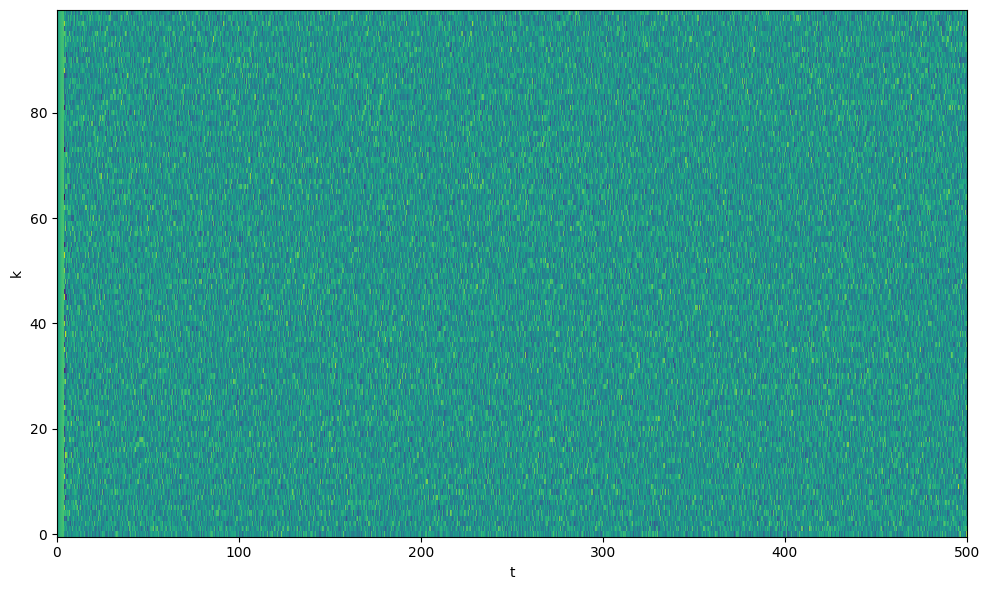

In [6]:
# Plot solution
plt.figure(figsize=(10, 6), dpi=100)
x = np.arange(I)
plt.pcolormesh( t_array,x,u_array[:I,:], 
               shading='nearest',cmap='viridis')
plt.xlabel('t')
plt.ylabel('k')
plt.tight_layout()
# plt.savefig("L96.png")
#c_array

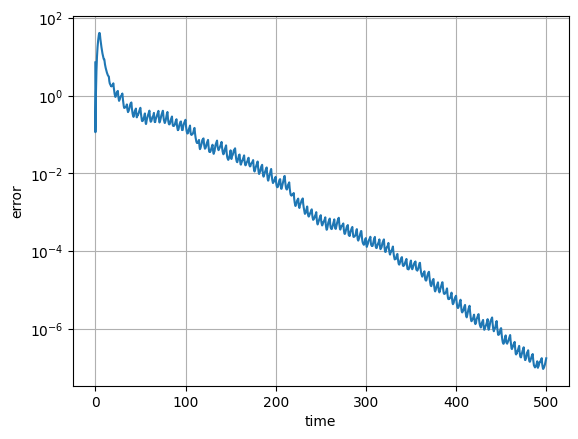

In [7]:
err = u_array - v_array
err_norm = np.linalg.norm(err,axis = 0)


plt.semilogy(t_array,err_norm)
plt.ylabel("error")
plt.xlabel("time")
plt.grid()

In [8]:
c_array

array([[ 2.00000000e-02,  1.00000000e+00],
       [-1.23487065e-04,  6.18395823e-01],
       [ 8.01873071e-03,  5.22938567e-01],
       [ 1.18410731e-02,  4.99617927e-01],
       [ 8.86247605e-03,  5.01005398e-01],
       [ 1.11066756e-02,  4.98954330e-01],
       [ 9.40371974e-03,  4.99888143e-01],
       [ 1.05907940e-02,  4.99340059e-01],
       [ 9.52171866e-03,  5.00252414e-01],
       [ 1.04162824e-02,  4.99673002e-01],
       [ 9.67285102e-03,  5.00186521e-01],
       [ 1.03732697e-02,  4.99505823e-01],
       [ 9.66210289e-03,  5.00294481e-01],
       [ 1.03802815e-02,  4.99590412e-01],
       [ 9.59353370e-03,  5.00386929e-01],
       [ 1.03309738e-02,  4.99830722e-01],
       [ 9.73850835e-03,  5.00112165e-01],
       [ 1.02420156e-02,  4.99814450e-01],
       [ 9.78835323e-03,  5.00150928e-01],
       [ 1.02109149e-02,  4.99807483e-01],
       [ 9.83697431e-03,  5.00060848e-01],
       [ 1.01292692e-02,  4.99920809e-01],
       [ 9.92510453e-03,  4.99985753e-01],
       [ 1.

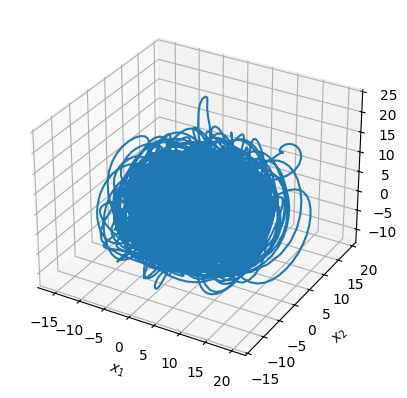

In [9]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.plot(u_array[0, :], u_array[1, :], u_array[2, :])
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_zlabel("$x_3$")
plt.show()

In [10]:
c_array[-1]

array([0.01, 0.5 ])

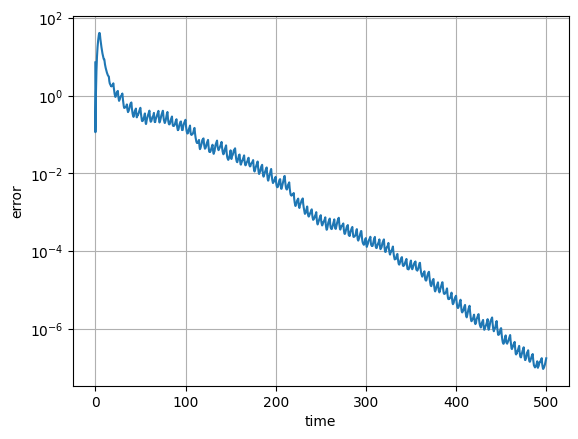

In [11]:
# Convergence of nudging
err = u_array - v_array
err_norm = np.linalg.norm(err,axis = 0)


plt.semilogy(t_array,err_norm)
plt.ylabel("error")
plt.xlabel("time")
plt.grid()
# plt.savefig("nudging_L96.png")

In [12]:
algs = ["newton","newton_A","LM","LM_A"]
Ns = [2000,800]

t_list = []
err_list = []
param_err_list = []
param_t_list = []

#set the dimensions of the system,
# I is the number of large scale systems 
# and J the number of small scale terms per each large scale
I=40
J=5
size=I*(J+1)


# Initial Conditions
u0 = np.random.rand(size)
v0 = np.random.rand(size)
w10 = np.zeros(size)
w20 = np.zeros(size)

# Learning Parameters
g = np.array([1e-2,0.5]) # True
paramErr = [1.,1.]
c_init = 2*g #+paramErr # Approximate
# Fixed Parameters
d = np.array([0.2,0.5,1,2,5]) #dissipation coefficients for the v_{k,j}
F=8. #forcing constant
dts = []

for j in range(4):
    
    algv = algs[j]
    
    
    # Initial State
    state0 = np.concatenate([u0,v0,w10,w20])

    # Running Parameters
    N = 2000 # Number of parameter updates
    t = 0 
    dt = 0.1
    n=100 # Number of steps per run
    
    mu=50.


    # Initialize variables
    state = np.array((size,n))
    u = np.array((size,n))
    v = np.array((size,n))
    w1 = np.array((size,n))
    w2 = np.array((size,n))
    c = c_init

    # Lists
    # variables
    ts = []
    us = []
    vs = []
    w1s = []
    w2s = []
    # parameters
    cs = [c_init]
    
    paramt = [0.]

    for i in range(N):
        # Integrate the system
        soln = solve_ivp(system, (t,t+dt), 
                         state0,
                         args = (I,J,g,c,F,d,mu), dense_output=True)

        # Interpolate in time
        trange = np.linspace(t,t+dt,n)
        #print(i)
        state = soln.sol(trange)
        #print(state.shape)
        u = state[0:size,:]
        v = state[size:2*size,:]
        w1 = state[2*size:3*size,:]
        w2 = state[3*size:,:]

        # Update time and initial conditions
        state0 = state[:,-1]
        t += dt


        c = updateParams(c,u[:I,-1],v[:I,-1],np.reshape(v[I:,-1],(I,J)),
                           w1[:I,-1],w2[:I,-1],alg=algv,r=10.,l=1e-6)

        #c = updateParamsOTF(c,u[:I,-1],v[0:I,-1],
        #                    np.reshape(v[I:,-1],(I,J)),
        #                    mu,r=1e-2,l=1e-6,alg = "newton")
        
        if i %10 == 0:
            print(j,",", i)

        # Append Lists
        us.append(u)
        vs.append(v)
        w1s.append(w1)
        w2s.append(w2)
        ts.append(trange)
        cs.append(c)
        
        paramt.append(t)

    u_array = np.concatenate(us, axis = 1)
    v_array = np.concatenate(vs, axis  = 1 )
    w1_array = np.concatenate(w1s, axis = 1)
    w2_array = np.concatenate(w2s, axis = 1)
    t_array = np.concatenate(ts)
    c_array = np.array(cs) 
    
    err = u_array - v_array
    err_norm = np.linalg.norm(err,axis = 0)
    paramerr = np.linalg.norm(c_array - g, axis = 1)

    
    # Save Data
    t_list.append(t_array)
    err_list.append(err_norm)
    param_t_list.append(paramt)
    param_err_list.append(paramerr)


0 , 0
0 , 10
0 , 20
0 , 30
0 , 40
0 , 50
0 , 60
0 , 70
0 , 80
0 , 90
0 , 100
0 , 110
0 , 120
0 , 130
0 , 140
0 , 150
0 , 160
0 , 170
0 , 180
0 , 190
0 , 200
0 , 210
0 , 220
0 , 230
0 , 240
0 , 250
0 , 260
0 , 270
0 , 280
0 , 290
0 , 300
0 , 310
0 , 320
0 , 330
0 , 340
0 , 350
0 , 360
0 , 370
0 , 380
0 , 390
0 , 400
0 , 410
0 , 420
0 , 430
0 , 440
0 , 450
0 , 460
0 , 470
0 , 480
0 , 490
0 , 500
0 , 510
0 , 520
0 , 530
0 , 540
0 , 550
0 , 560
0 , 570
0 , 580
0 , 590
0 , 600
0 , 610
0 , 620
0 , 630
0 , 640
0 , 650
0 , 660
0 , 670
0 , 680
0 , 690
0 , 700
0 , 710
0 , 720
0 , 730
0 , 740
0 , 750
0 , 760
0 , 770
0 , 780
0 , 790
0 , 800
0 , 810
0 , 820
0 , 830
0 , 840
0 , 850
0 , 860
0 , 870
0 , 880
0 , 890
0 , 900
0 , 910
0 , 920
0 , 930
0 , 940
0 , 950
0 , 960
0 , 970
0 , 980
0 , 990
0 , 1000
0 , 1010
0 , 1020
0 , 1030
0 , 1040
0 , 1050
0 , 1060
0 , 1070
0 , 1080
0 , 1090
0 , 1100
0 , 1110
0 , 1120
0 , 1130
0 , 1140
0 , 1150
0 , 1160
0 , 1170
0 , 1180
0 , 1190
0 , 1200
0 , 1210
0 , 1220
0 , 

## Plots Generated Below

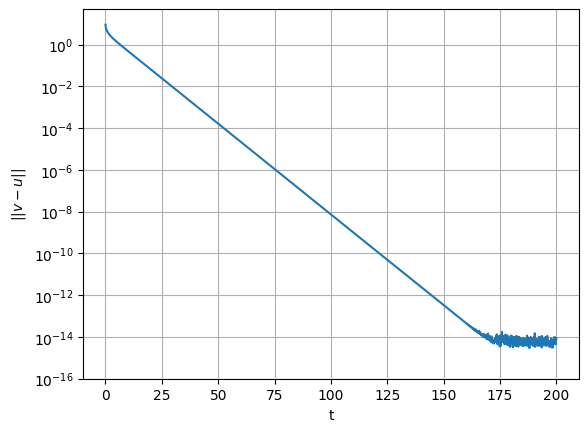

In [13]:
# Convergence of nudging


t_list = []
err_list = []
param_err_list = []
param_t_list = []
c_list = []

#set the dimensions of the system,
# I is the number of large scale systems 
# and J the number of small scale terms per each large scale
I=40
J=5
size=I*(J+1)


# Initial Conditions
u0 = np.random.rand(size)
v0 = np.zeros(size)
w10 = np.zeros(size)
w20 = np.zeros(size)

# Learning Parameters
g = np.array([1e-2,0.5]) # True
eps = 0
c_init = (1+eps)*g #+paramErr # Approximate
# Fixed Parameters
d = np.array([0.2,0.5,1,2,5]) #dissipation coefficients for the v_{k,j}
F=8. #forcing constant
dts = [5e-2,0.1,0.5,1.,5.]

# Initial State
state0 = np.concatenate([u0,v0,w10,w20])

# Running Parameters
# Number of parameter updates
T = 200
dt = 10
N = int(T/dt)
t = 0 
n=100 # Number of steps per run

mu=50.


# Initialize variables
state = np.array((size,n))
u = np.array((size,n))
v = np.array((size,n))
w1 = np.array((size,n))
w2 = np.array((size,n))
c = c_init

# Lists
# variables
ts = []
us = []
vs = []
w1s = []
w2s = []
# parameters
cs = [c_init]

paramt = [0.]

for i in range(N):
    # Integrate the system
    soln = solve_ivp(system, (t,t+dt), 
                     state0,
                     args = (I,J,g,c,F,d,mu), dense_output=True)

    # Interpolate in time
    trange = np.linspace(t,t+dt,n)
    #print(i)
    state = soln.sol(trange)
    #print(state.shape)
    u = state[0:size,:]
    v = state[size:2*size,:]
    w1 = state[2*size:3*size,:]
    w2 = state[3*size:,:]

    # Update time and initial conditions
    state0 = state[:,-1]
    t += dt



    # Append Lists
    us.append(u)
    vs.append(v)
    w1s.append(w1)
    w2s.append(w2)
    ts.append(trange)
    cs.append(c)

    paramt.append(t)

u_array = np.concatenate(us, axis = 1)
v_array = np.concatenate(vs, axis  = 1 )
w1_array = np.concatenate(w1s, axis = 1)
w2_array = np.concatenate(w2s, axis = 1)
t_array = np.concatenate(ts)
c_array = np.array(cs) 

err = u_array - v_array
err_norm = np.linalg.norm(err,axis = 0)
paramerr = np.linalg.norm(c_array - g, axis = 1)


# Save Data
t_list.append(t_array)
err_list.append(err_norm)
param_t_list.append(paramt)
param_err_list.append(paramerr)
c_list.append(c_array)



fig, axs = plt.subplots(1, 1)
y0, y1 = 1e-16,5e1




axs.semilogy(t_list[0], err_list[0],label = "$||v - u||$" )
axs.set_ylim(y0,y1)
axs.set_xlabel("t")
axs.set_ylabel("$||v-u||$")
axs.grid()

# fig.savefig("nudging_L96.png")
plt.show()

In [14]:
# Sensitivity to dt
algs = ["newton","newton_A","LM","LM_A"]

t_list = []
err_list = []
param_err_list = []
param_t_list = []
c_list = []

#set the dimensions of the system,
# I is the number of large scale systems 
# and J the number of small scale terms per each large scale
I=40
J=5
size=I*(J+1)



w10 = np.zeros(size)
w20 = np.zeros(size)

# Learning Parameters
g = np.array([1e-2,0.5]) # True
eps = 1e-3
c_init = (1+eps)*g #+paramErr # Approximate
# Fixed Parameters
d = np.array([0.2,0.5,1,2,5]) #dissipation coefficients for the v_{k,j}
F=8. #forcing constant
dts = [5e-2,0.1,0.5,1.,5.]

for algv in algs:
    for i in range(10):

        # Initial State
        state0 = np.concatenate([u0,v0,w10,w20])
        
        # Initial Conditions
        u0 = np.random.rand(size)
        v0 = np.zeros(size)

        # Running Parameters
        # Number of parameter updates
        T = 100
        N = int(T/dt)
        t = 0 
        n=100 # Number of steps per run

        mu=50.


        # Initialize variables
        state = np.array((size,n))
        u = np.array((size,n))
        v = np.array((size,n))
        w1 = np.array((size,n))
        w2 = np.array((size,n))
        c = c_init

        # Lists
        # variables
        ts = []
        us = []
        vs = []
        w1s = []
        w2s = []
        # parameters
        cs = [c_init]

        paramt = [0.]

        for i in range(N):
            # Integrate the system
            soln = solve_ivp(system, (t,t+dt), 
                             state0,
                             args = (I,J,g,c,F,d,mu), dense_output=True)

            # Interpolate in time
            trange = np.linspace(t,t+dt,n)
            #print(i)
            state = soln.sol(trange)
            #print(state.shape)
            u = state[0:size,:]
            v = state[size:2*size,:]
            w1 = state[2*size:3*size,:]
            w2 = state[3*size:,:]

            # Update time and initial conditions
            state0 = state[:,-1]
            t += dt


            c = updateParams(c,u[:I,-1],v[:I,-1],np.reshape(v[I:,-1],(I,J)),
                               w1[:I,-1],w2[:I,-1],alg=algv,r=10.,l=1e-6)

            #c = updateParamsOTF(c,u[:I,-1],v[0:I,-1],
            #                    np.reshape(v[I:,-1],(I,J)),
            #                    mu,r=1e-2,l=1e-6,alg = "newton")

            #if i %10 == 0:
                #print(j,",", i)

            # Append Lists
            us.append(u)
            vs.append(v)
            w1s.append(w1)
            w2s.append(w2)
            ts.append(trange)
            cs.append(c)

            paramt.append(t)

        u_array = np.concatenate(us, axis = 1)
        v_array = np.concatenate(vs, axis  = 1 )
        w1_array = np.concatenate(w1s, axis = 1)
        w2_array = np.concatenate(w2s, axis = 1)
        t_array = np.concatenate(ts)
        c_array = np.array(cs) 

        err = u_array - v_array
        err_norm = np.linalg.norm(err,axis = 0)
        paramerr = np.linalg.norm(c_array - g, axis = 1)


        # Save Data
        t_list.append(t_array)
        err_list.append(err_norm)
        param_t_list.append(paramt)
        param_err_list.append(paramerr)
        c_list.append(c_array)

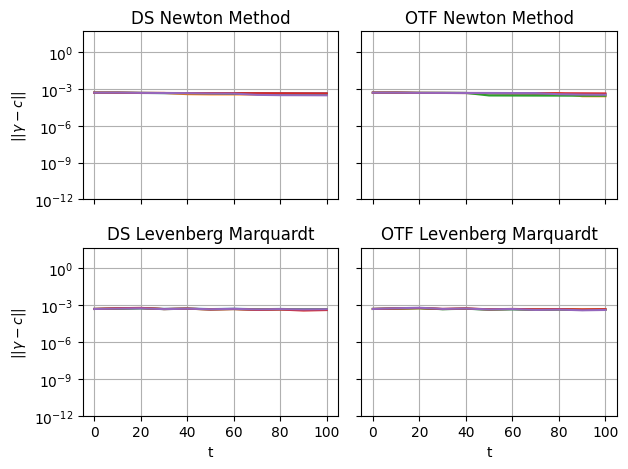

In [15]:
fig, axs = plt.subplots(2, 2)
y0, y1 = 1e-12,5e1

ax = axs[0, 0]
ax.set_title('DS Newton Method')
for i in range(5):
    ax.semilogy(param_t_list[0 + i], param_err_list[0 + i],label = "$\Delta t$ = " +str(dts[i]) )
ax.set_ylim(y0,y1)
ax.grid()

axs[0,1].set_title('OTF Newton Method')
for i in range(5):
    axs[0,1].semilogy(param_t_list[5 + i], param_err_list[5 + i],label = "$\Delta t$ = " +str(dts[i]) )
axs[0,1].set_ylim(y0,y1)
#axs[0,1].legend(loc = "upper right")
axs[0,1].grid()

axs[1,0].set_title('DS Levenberg Marquardt')
for i in range(5):
    axs[1,0].semilogy(param_t_list[10 + i], param_err_list[10 + i],label = "$\Delta t$ = " +str(dts[i]) )
axs[1,0].set_ylim(y0,y1)

axs[1,0].grid()

axs[1,1].set_title('OTF Levenberg Marquardt')
for i in range(5):
    axs[1,1].semilogy(param_t_list[15 + i], param_err_list[15 + i],label = "$\Delta t$ = " +str(dts[i]) )
axs[1,1].set_ylim(y0,y1)
axs[1,1].grid()


for ax in axs.flat:
    ax.set(xlabel='t', ylabel='$||\gamma-c||$')
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
fig.tight_layout()
# fig.savefig("SensitivitytoDT_L96.png")
plt.show()

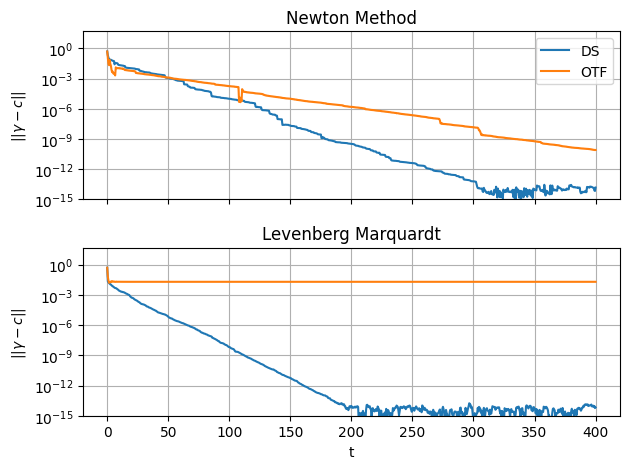

In [318]:
# DS vs OTF
algs = ["newton","newton_A","LM","LM_A"]
Ns = [2000,800]

t_list = []
err_list = []
param_err_list = []
param_t_list = []
c_list = []

#set the dimensions of the system,
# I is the number of large scale systems 
# and J the number of small scale terms per each large scale
I=40
J=5
size=I*(J+1)


# Initial Conditions
u0 = np.random.rand(size)
v0 = np.zeros(size)
#v0 = np.random.rand(size)
w10 = np.zeros(size)
w20 = np.zeros(size)

# Learning Parameters
g = np.array([1e-2,0.5]) # True
eps = 1
c_init = (1+eps)*g #+paramErr # Approximate
# Fixed Parameters
d = np.array([0.2,0.5,1,2,5]) #dissipation coefficients for the v_{k,j}
F=8. #forcing constant


for j in range(4):
    
    algv = algs[j]
    
    
    # Initial State
    state0 = np.concatenate([u0,v0,w10,w20])

    # Running Parameters
    T =400
    N = int(T/dt) # Number of parameter updates
    t = 0 
    dt = 0.5
    n=100 # Number of steps per run
    
    mu=50.


    # Initialize variables
    state = np.array((size,n))
    u = np.array((size,n))
    v = np.array((size,n))
    w1 = np.array((size,n))
    w2 = np.array((size,n))
    c = c_init

    # Lists
    # variables
    ts = []
    us = []
    vs = []
    w1s = []
    w2s = []
    # parameters
    cs = [c_init]
    
    paramt = [0.]

    for i in range(N):
        # Integrate the system
        soln = solve_ivp(system, (t,t+dt), 
                         state0,
                         args = (I,J,g,c,F,d,mu), dense_output=True)

        # Interpolate in time
        trange = np.linspace(t,t+dt,n)
        #print(i)
        state = soln.sol(trange)
        #print(state.shape)
        u = state[0:size,:]
        v = state[size:2*size,:]
        w1 = state[2*size:3*size,:]
        w2 = state[3*size:,:]

        # Update time and initial conditions
        state0 = state[:,-1]
        t += dt


        c = updateParams(c,u[:I,-1],v[:I,-1],np.reshape(v[I:,-1],(I,J)),
                           w1[:I,-1],w2[:I,-1],alg=algv,r=10.,l=1e-9)

        #c = updateParamsOTF(c,u[:I,-1],v[0:I,-1],
        #                    np.reshape(v[I:,-1],(I,J)),
        #                    mu,r=1e-2,l=1e-6,alg = "newton")
        
        #if i %10 == 0:
            #print(j,",", i)

        # Append Lists
        us.append(u)
        vs.append(v)
        w1s.append(w1)
        w2s.append(w2)
        ts.append(trange)
        cs.append(c)
        
        paramt.append(t)

    u_array = np.concatenate(us, axis = 1)
    v_array = np.concatenate(vs, axis  = 1 )
    w1_array = np.concatenate(w1s, axis = 1)
    w2_array = np.concatenate(w2s, axis = 1)
    t_array = np.concatenate(ts)
    c_array = np.array(cs) 
    
    err = u_array - v_array
    err_norm = np.linalg.norm(err,axis = 0)
    paramerr = np.linalg.norm(c_array - g, axis = 1)

    
    # Save Data
    t_list.append(t_array)
    err_list.append(err_norm)
    param_t_list.append(paramt)
    param_err_list.append(paramerr)
    c_list.append(c_array)



fig, axs = plt.subplots(2, 1)
y0, y1 = 1e-15,5e1

axs[0].set_title('Newton Method')
axs[0].semilogy(param_t_list[0], param_err_list[0],label = "DS")
axs[0].semilogy(param_t_list[1], param_err_list[1],label = "OTF")
axs[0].legend(loc = "upper right")
axs[0].set_ylim(y0,y1)
axs[0].grid()

axs[1].set_title('Levenberg Marquardt')
axs[1].semilogy(param_t_list[2], param_err_list[2],label = "DS")
axs[1].semilogy(param_t_list[3], param_err_list[3],label = "OTF")
axs[1].set_ylim(y0,y1)
axs[1].grid()

for ax in axs.flat:
    ax.set(xlabel='t', ylabel='$||\gamma - c||$')
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
fig.tight_layout()
# fig.savefig("DSvsOTF_L96.png")
plt.show()

In [319]:
c_list[-1]

array([[ 0.02      ,  1.        ],
       [-0.04994471,  0.52274727],
       [-0.00940357,  0.4825003 ],
       ...,
       [-0.01      ,  0.5       ],
       [-0.01      ,  0.5       ],
       [-0.01      ,  0.5       ]])

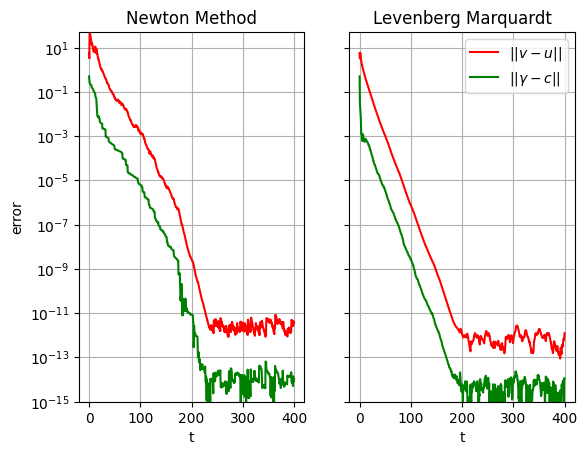

In [298]:
# Newton vs LM
algs = ["newton","LM"]
Ns = [800,800]

t_list = []
err_list = []
param_err_list = []
param_t_list = []

#set the dimensions of the system,
# I is the number of large scale systems 
# and J the number of small scale terms per each large scale
I=40
J=5
size=I*(J+1)


# Initial Conditions
u0 = np.random.rand(size)
v0 = np.random.rand(size)
w10 = np.zeros(size)
w20 = np.zeros(size)

# Learning Parameters
g = np.array([1e-2,0.5]) # True
#paramErr = [1.,1.]
c_init = 2*g #+paramErr # Approximate
# Fixed Parameters
d = np.array([0.2,0.5,1,2,5]) #dissipation coefficients for the v_{k,j}
F=8. #forcing constant
dts = []

for j in range(2):
    
    algv = algs[j]
    
    
    # Initial State
    state0 = np.concatenate([u0,v0,w10,w20])

    # Running Parameters
    N = Ns[j] # Number of parameter updates
    t = 0 
    dt = 0.5
    n=100 # Number of steps per run
    
    mu=50.


    # Initialize variables
    state = np.array((size,n))
    u = np.array((size,n))
    v = np.array((size,n))
    w1 = np.array((size,n))
    w2 = np.array((size,n))
    c = c_init

    # Lists
    # variables
    ts = []
    us = []
    vs = []
    w1s = []
    w2s = []
    # parameters
    cs = [c_init]
    
    paramt = [0.]

    for i in range(N):
        # Integrate the system
        soln = solve_ivp(system, (t,t+dt), 
                         state0,
                         args = (I,J,g,c,F,d,mu), dense_output=True)

        # Interpolate in time
        trange = np.linspace(t,t+dt,n)
        #print(i)
        state = soln.sol(trange)
        #print(state.shape)
        u = state[0:size,:]
        v = state[size:2*size,:]
        w1 = state[2*size:3*size,:]
        w2 = state[3*size:,:]

        # Update time and initial conditions
        state0 = state[:,-1]
        t += dt


        c = updateParams(c,u[:I,-1],v[:I,-1],np.reshape(v[I:,-1],(I,J)),
                           w1[:I,-1],w2[:I,-1],alg=algv,r=10.,l=1e-6)

        #c = updateParamsOTF(c,u[:I,-1],v[0:I,-1],
        #                    np.reshape(v[I:,-1],(I,J)),
        #                    mu,r=1e-2,l=1e-6,alg = "newton")
        
        #if i %10 == 0:
        #    print(j,",", i)

        # Append Lists
        us.append(u)
        vs.append(v)
        w1s.append(w1)
        w2s.append(w2)
        ts.append(trange)
        cs.append(c)
        
        paramt.append(t)

    u_array = np.concatenate(us, axis = 1)
    v_array = np.concatenate(vs, axis  = 1 )
    w1_array = np.concatenate(w1s, axis = 1)
    w2_array = np.concatenate(w2s, axis = 1)
    t_array = np.concatenate(ts)
    c_array = np.array(cs) 
    
    err = u_array - v_array
    err_norm = np.linalg.norm(err,axis = 0)
    paramerr = np.linalg.norm(c_array - g, axis = 1)

    
    # Save Data
    t_list.append(t_array)
    err_list.append(err_norm)
    param_t_list.append(paramt)
    param_err_list.append(paramerr)



y0 = 1e-15
y1 = 5e1

fig, axs = plt.subplots(1, 2)
axs[0].semilogy(t_list[0], err_list[0],color = 'red')
axs[0].semilogy(param_t_list[0], param_err_list[0],color='green')
axs[0].set_title('Newton Method')
axs[0].set_ylim( (y0,y1) )
axs[0].grid()
#axs[0, 1].plot(x, y, 'tab:orange')
axs[1].semilogy(t_list[1], err_list[1],label="$||v-u||$",color='red')
axs[1].semilogy(param_t_list[1], param_err_list[1],label="$||\gamma - c||$",color='green')
axs[1].set_title('Levenberg Marquardt')
axs[1].set_ylim( (y0,y1) )
axs[1].legend(loc = "upper right")
axs[1].grid()


for ax in axs.flat:
    ax.set(xlabel='t', ylabel='error')
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
# fig.savefig("newtonvsLM_DS_L96.png")
plt.show()